In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# Importación y análisis de los datos
rcParams['figure.figsize'] = 14, 8

Using TensorFlow backend.


# Importación y análisis de los datos
Convertimos todos los datos a valores numéricos

In [31]:
df = pd.read_csv("data/base_sintetica.csv", encoding="Latin-1")

In [32]:

df[["IP1","IP2","IP3","IP4"]]=df['IP Terminal'].str.split('.', 3,expand=True)
df=df.drop("IP Terminal", axis=1)
#Mantenemos el orden
cols = df.columns.tolist()
cols = cols[:3] + cols[-4:] + cols[3:-4]
df = df[cols]

In [33]:
df.shape

(104996, 15)

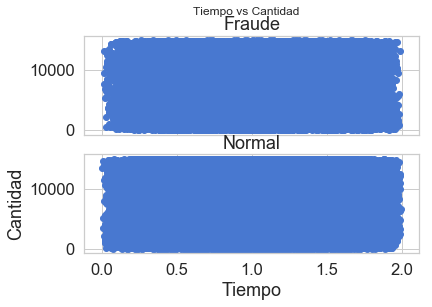

In [34]:
#Notamos que las transacciones fraudulentas no dependen del tiempo
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Tiempo vs Cantidad')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraude')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Tiempo')
plt.ylabel('Cantidad')
plt.show()

#De la misma forma se puede ver que los sucesos fraudulentos tampoco dependen de las variables Date, Country Type and Shopping type

In [35]:
# Nos deshacemos de esas variables
df = df.drop(['Time',"Date","Country","Type","Shopping Type"], axis=1)

df.dtypes

ID Client               int64
IP1                    object
IP2                    object
IP3                    object
IP4                    object
Amount                  int64
City                   object
State                  object
Travel Notification     int64
Class                   int64
dtype: object

In [9]:
cols_to_transform = [ "City" ,"State"]
df = pd.get_dummies( df,columns = cols_to_transform )

In [10]:
df.shape

(104996, 89)

In [11]:
df.isnull().values.any()

False

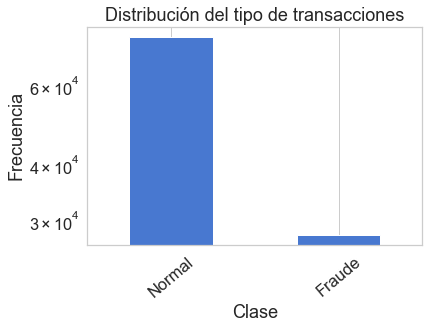

In [12]:
tipo_transaccion = pd.value_counts(df['Class'])
tipo_transaccion.plot(kind = 'bar',rot=2200)
plt.title("Distribución del tipo de transacciones")
plt.xticks(range(2), ["Normal","Fraude"])
plt.xlabel("Clase")
plt.ylabel("Frecuencia");
plt.yscale("log")

# Preprocesamiento

Removemos las columnas independientes de las transacciones fraudulentas y normalizamos los datos

In [14]:
from sklearn.preprocessing import StandardScaler
data=df
cols = data.columns.drop("Class")
data[cols] = StandardScaler().fit_transform(data[cols])

C:\Users\P51S LENOVO\Anaconda3\envs\tensor\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\P51S LENOVO\Anaconda3\envs\tensor\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Tenemos que lidear con un problema de un conjunto de datos muy desbalanceado. Para hacer esto, una de las propuestas es entrenar un autocodificador sobre transacciones normales. Así, cuando aparezca una transaccion anormal, se etiquetará como fraudulenta. 

In [54]:
data_normal = data[data.Class == 0]
data_fraud = data[data.Class == 1]
drop_indices = np.random.choice(data_fraud.index,22000,replace=False)
data_fraud = data_fraud.drop(drop_indices)
#El 20% de los datos se usará para testear el algoritmo
X_train, X_test = train_test_split(data_normal, test_size=0.2)

#Ya no necesitamos la columna de tipo de transaccion, pues todas seran normales
X_train = X_train.drop(['Class'], axis=1)


X_test_with_fraud = pd.concat([X_test,data_fraud])
clase_test = X_test_with_fraud['Class']
X_test_with_fraud = X_test_with_fraud.drop(['Class'],axis=1)
X_test_without_fraud = X_test.drop(['Class'], axis=1)


#Convirtiendo a numpy array
X_train = X_train.values
X_test_without_fraud = X_test_without_fraud.values
X_test_with_fraud = X_test_with_fraud.values

# Algoritmo IA

### Auto-codificador (Autoencoder)

4 capas completamente conectadas (dos para el codificador y dos para el decodificador) con n1, n2, n3, n4 neuronas. 

Regularización L1

In [58]:
input_dim = X_train.shape[1]
n1 = 50
n2 = n1/2
n3 = n1/2
n4 = input_dim #Pues el output tiene que ser del mismo tamaño que el input

In [59]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(n1, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(n2), activation="relu")(encoder)

decoder = Dense(int(n3), activation='tanh')(encoder)
decoder = Dense(n4, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [60]:
df.dtypes

ID Client               int64
IP1                    object
IP2                    object
IP3                    object
IP4                    object
Amount                  int64
City                   object
State                  object
Travel Notification     int64
Class                   int64
dtype: object

In [61]:
nb_epoch = 50
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_without_fraud, X_test_without_fraud),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 61685 samples, validate on 15422 samples
Epoch 1/50
61685/61685 [==============================] - 2s 32us/step - loss: 0.5918 - acc: 0.6836 - val_loss: 0.3798 - val_acc: 0.7535
Epoch 2/50
61685/61685 [==============================] - 2s 32us/step - loss: 0.3511 - acc: 0.7950 - val_loss: 0.3095 - val_acc: 0.7951
Epoch 3/50
61685/61685 [==============================] - 2s 32us/step - loss: 0.3087 - acc: 0.7900 - val_loss: 0.2826 - val_acc: 0.8447
Epoch 4/50
61685/61685 [==============================] - 2s 32us/step - loss: 0.2918 - acc: 0.7846 - val_loss: 0.2723 - val_acc: 0.7635
Epoch 5/50
61685/61685 [==============================] - 2s 35us/step - loss: 0.2825 - acc: 0.7914 - val_loss: 0.2635 - val_acc: 0.7847
Epoch 6/50
61685/61685 [==============================] - 2s 33us/step - loss: 0.2759 - acc: 0.8002 - val_loss: 0.2603 - val_acc: 0.7586
Epoch 7/50
61685/61685 [==============================] - 2s 32us/step - loss: 0.2715 - acc: 0.8008 - val_loss: 0.2561 - val_acc

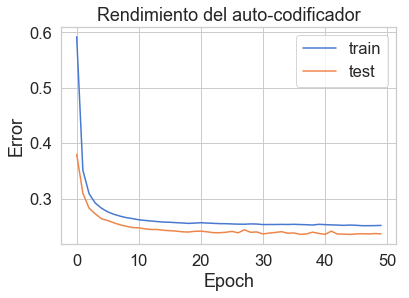

In [62]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Rendimiento del auto-codificador')
plt.ylabel("Error")
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right');

In [63]:
predictions = autoencoder.predict(X_test_with_fraud)

In [64]:
#Mean square error of the test data with the test data passed through the encoder
mse = np.mean(np.power(X_test_with_fraud - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': clase_test})

In [65]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

# Precisión y exhaustividad:

$$\text{Precision} = \frac{\text{verdadero positivo}}{\text{verdadero positivo} + \text{falso positivo}}$$

$$\text{Exhaustividad} = \frac{\text{verdadero positivo}}{\text{verdadero positivo} + \text{falso negativo}}$$

Situación ideal: $\text{Precision} = \text{Exhaustividad} = 1$

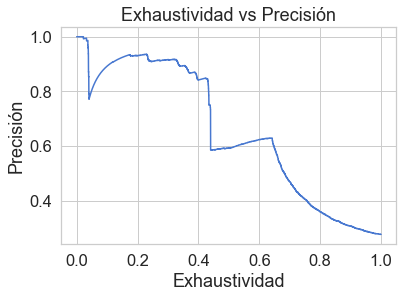

In [66]:
#Utilizando herramientas de keras, calculamos la precision y la exhaustividad para distintos threshold
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Exhaustividad vs Precisión')
plt.xlabel('Exhaustividad')
plt.ylabel('Precisión')
plt.show()

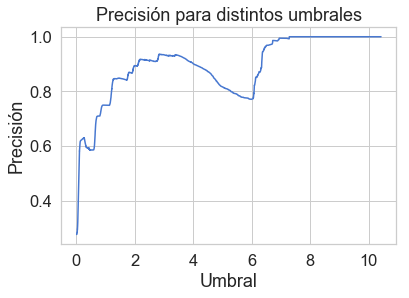

In [67]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precisión para distintos umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precisión')
plt.show()

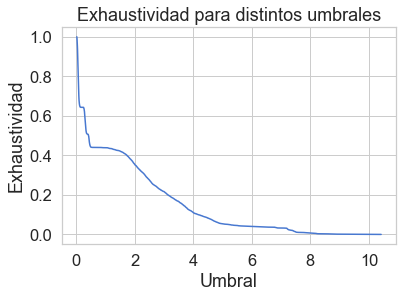

In [68]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Exhaustividad para distintos umbrales')
plt.xlabel('Umbral')
plt.ylabel('Exhaustividad')
plt.show()

# Predicción

In [72]:
threshold = 1.7

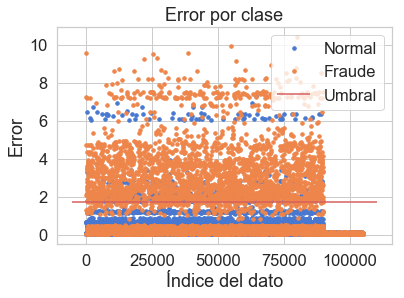

In [73]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraude" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Umbral')
ax.legend()
plt.title("Error por clase")
plt.ylabel("Error")
plt.xlabel("Índice del dato")
plt.show();

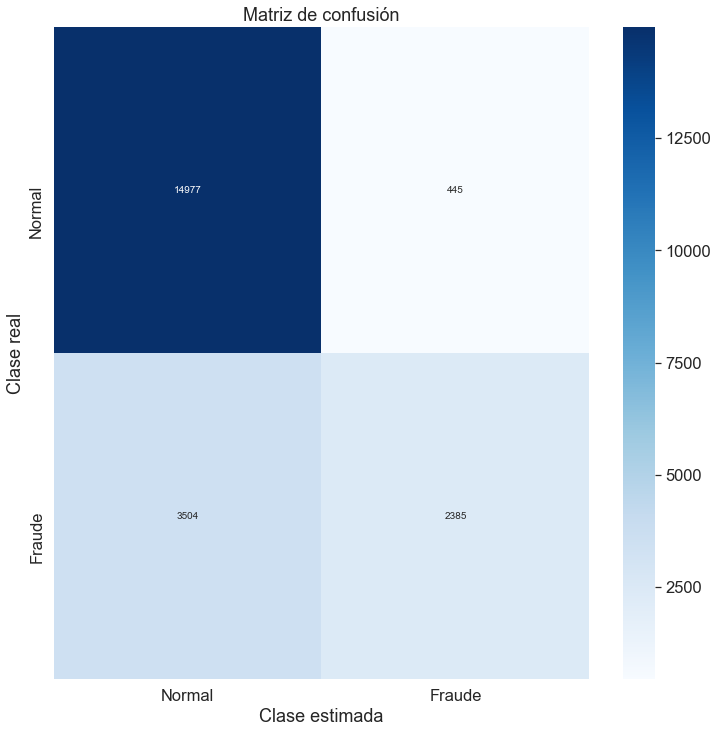

In [74]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, cmap="Blues", xticklabels=["Normal" , "Fraude"], yticklabels=["Normal","Fraude"], annot=True, fmt="d");
plt.title("Matriz de confusión")
plt.ylabel('Clase real')
plt.xlabel('Clase estimada')
plt.show()

In [75]:
#print("Tasa de fraudes detectados: %d%%" % (407/492*100))
#print("Tasa de falsos positivos: %d%%" %(1225/55638*100))
#print("Solo %d%% detectados como fraudulentos fueron fraudulentos" %(407/1632*100))